## Comodo Example
This examples, load a basic robot model (i.e. composed only of basic shapes), modifies the links of such a robot model by elongating the legs, define instances of the TSID (Task Based Inverse Dynamics) and Centroidal MPC  controller and simulate the behavior of the robot using drake.  

In [1]:
import sys

sys.path.append("/home/wslaniakea/git/research/comodo/src/")


# Comodo import
from comodo.drakeSimulator.drakeSimulator import DrakeSimulator
from comodo.robotModel.robotModel import RobotModel
from comodo.robotModel.createUrdf import createUrdf
from comodo.centroidalMPC.centroidalMPC import CentroidalMPC
from comodo.centroidalMPC.mpcParameterTuning import MPCParameterTuning
from comodo.TSIDController.TSIDParameterTuning import TSIDParameterTuning
from comodo.TSIDController.TSIDController import TSIDController

In [2]:
# General  import 
import xml.etree.ElementTree as ET
import numpy as np
import tempfile
import urllib.request
import logging

In [3]:
# set the logging level
logging.getLogger().setLevel(logging.INFO)

In [4]:
# Getting stickbot urdf file and convert it to string 
urdf_robot_file = tempfile.NamedTemporaryFile(mode="w+")
url = 'https://raw.githubusercontent.com/icub-tech-iit/ergocub-gazebo-simulations/master/models/stickBot/model.urdf'
urllib.request.urlretrieve(url, urdf_robot_file.name)
# Load the URDF file
tree = ET.parse(urdf_robot_file.name)
root = tree.getroot()

# Convert the XML tree to a string
robot_urdf_string_original = ET.tostring(root)

create_urdf_instance = createUrdf(
    original_urdf_path=urdf_robot_file.name, save_gazebo_plugin=False
)

In [5]:
# Define parametric links and controlled joints  
legs_link_names = ["hip_3", "lower_leg"]
joint_name_list = [
    "r_shoulder_pitch",
    "r_shoulder_roll",
    "r_shoulder_yaw",
    "r_elbow",
    "l_shoulder_pitch",
    "l_shoulder_roll",
    "l_shoulder_yaw",
    "l_elbow",
    "r_hip_pitch",
    "r_hip_roll",
    "r_hip_yaw",
    "r_knee",
    "r_ankle_pitch",
    "r_ankle_roll",
    "l_hip_pitch",
    "l_hip_roll",
    "l_hip_yaw",
    "l_knee",
    "l_ankle_pitch",
    "l_ankle_roll",
]

In [6]:
# Define the robot modifications
modifications = {}
for item in legs_link_names:
    left_leg_item = "l_" + item
    right_leg_item = "r_" + item
    modifications.update({left_leg_item: 1.2})
    modifications.update({right_leg_item: 1.2})
# Motors Parameters 
Im_arms = 1e-3*np.ones(4) # from 0-4
Im_legs = 1e-3*np.ones(6) # from 5-10
kv_arms = 0.001*np.ones(4) # from 11-14
kv_legs = 0.001*np.ones(6) #from 20

Im = np.concatenate((Im_arms, Im_arms, Im_legs, Im_legs))
kv = np.concatenate((kv_arms, kv_arms, kv_legs, kv_legs))

In [7]:
# Modify the robot model and initialize
create_urdf_instance.modify_lengths(modifications)
urdf_robot_string = create_urdf_instance.write_urdf_to_file()
create_urdf_instance.reset_modifications()
robot_model_init = RobotModel(urdf_robot_string, "stickBot", joint_name_list=joint_name_list, mesh_path=None)
s_des, xyz_rpy, H_b = robot_model_init.compute_desired_position_walking()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      118
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      142

Total number of variables............................:       27
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       14
Total number of inequality c

In [8]:
# Define simulator and initial position
drake_instance = DrakeSimulator()
drake_instance.set_visualize_robot_flag(True)
drake_instance.load_model(robot_model_init, s=s_des, xyz_rpy=xyz_rpy, kv_motors=kv, Im=Im, keep_collision_meshes=['l_foot_rear', 'l_foot_front', 'r_foot_rear', 'r_foot_front'])
s, ds, tau = drake_instance.get_state()
t = drake_instance.get_simulation_time()
H_b = drake_instance.get_base()
# beware of the velocity ordering
w_b = drake_instance.get_base_velocity()

INFO:root:Visualisation for drake via meshcat can be accessd via the url output from the execution.
INFO:drake:Meshcat listening for connections at http://localhost:7000


In [ ]:
TSIDParameterTuning()

[DEBUG] [2024-06-13 14:45:10.051] [thread: 29845] [blf] [StdImplementation::getParameterPrivate] Parameter named 'verbosity' not found.
[INFO] [2024-06-13 14:45:10.051] [thread: 29845] [blf] [QPTSID::initialize] 'verbosity' not found. The following parameter will be used 'false'.
[DEBUG] [2024-06-13 14:45:10.051] [thread: 29845] [blf] [StdImplementation::getParameterPrivate] Parameter named 'mask' not found.
[INFO] [2024-06-13 14:45:10.051] [thread: 29845] [blf] [CoMTask::initialize] [CoMTask Task.] Unable to find the mask parameter. The default value is used: true true true.
[DEBUG] [2024-06-13 14:45:10.051] [thread: 29845] [blf] [StdImplementation::getParameterPrivate] Parameter named 'mask' not found.
[INFO] [2024-06-13 14:45:10.051] [thread: 29845] [blf] [SE3Task::initialize]  [SE3Task Optimal Control Element - Frame name:  l_sole] Unable to find the mask parameter. The default value is used: true true true.
[DEBUG] [2024-06-13 14:45:10.052] [thread: 29845] [blf] [StdImplementation

[ERROR] [2024-06-13 14:45:10.051] [thread: 29845] [blf] [JointTrackingTask::initialize] The size of the kp gain does not match with the one stored in kinDynComputations object. Expected: 20. Given: 8
[ERROR] [2024-06-13 14:45:10.052] [thread: 29845] [blf] [QPTSID::addTask] - [Task name: 'joint_regularization_task'] The size of the weight is not coherent with the size of the task. Expected: 20. Given: 8.


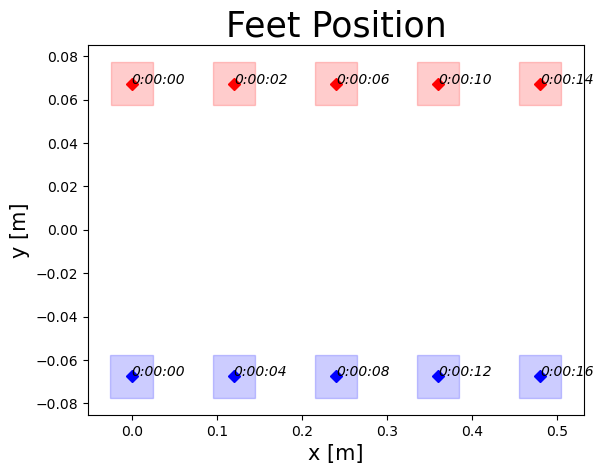

In [9]:
# Define the controller parameters  and instantiate the controller
# Controller Parameters
tsid_parameter = TSIDParameterTuning()
mpc_parameters = MPCParameterTuning()

# TSID Instance
TSID_controller_instance = TSIDController(frequency=0.01, robot_model=robot_model_init)
TSID_controller_instance.define_tasks(tsid_parameter)
TSID_controller_instance.set_state_with_base(s, ds, H_b, w_b, t)

# MPC Instance
step_length = 0.1
mpc = CentroidalMPC(robot_model=robot_model_init, step_length=step_length)
mpc.intialize_mpc(mpc_parameters=mpc_parameters)

# Set desired quantities
mpc.configure(s_init=s_des, H_b_init=H_b)
TSID_controller_instance.compute_com_position()
mpc.define_test_com_traj(TSID_controller_instance.COM.toNumPy())

# TODO: Set initial robot state and plan trajectories 
drake_instance.step(1)

# Reading the state 
s, ds, tau = drake_instance.get_state()
H_b = drake_instance.get_base()
w_b = drake_instance.get_base_velocity()
t = drake_instance.get_simulation_time()

# MPC
mpc.set_state_with_base(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)
mpc.initialize_centroidal_integrator(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)
mpc_output = mpc.plan_trajectory()

In [10]:
# Set loop variables 
TIME_TH = 20.0

# Define number of steps
n_step = int(
    TSID_controller_instance.frequency / drake_instance.get_simulation_frequency()
)
n_step_mpc_tsid = int(mpc.get_frequency_seconds() / TSID_controller_instance.frequency)

counter = 0
mpc_success = True
energy_tot = 0.0
succeded_controller = True

In [12]:
# Simulation-control loop
if  drake_instance.visualize_robot_flag:
    drake_instance.meshcat.StartRecording()
while t < TIME_TH:
    
    # Reading robot state from simulator
    s, ds, tau = drake_instance.get_state()
    energy_i = np.linalg.norm(tau)
    H_b = drake_instance.get_base()
    w_b = drake_instance.get_base_velocity()
    t = drake_instance.get_simulation_time()

    # Update TSID
    TSID_controller_instance.set_state_with_base(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)

    # MPC plan 
    if counter == 0:
        mpc.set_state_with_base(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)
        mpc.update_references()
        mpc_success = mpc.plan_trajectory()
        mpc.contact_planner.advance_swing_foot_planner()
        if not (mpc_success):
            logging.error("MPC failed")
            break

    # Reading new references
    com, dcom, forces_left, forces_right, _ = mpc.get_references()
    left_foot, right_foot = mpc.contact_planner.get_references_swing_foot_planner()

    # Update references TSID 
    TSID_controller_instance.update_task_references_mpc(
        com=com,
        dcom=dcom,
        ddcom=np.zeros(3),
        left_foot_desired=left_foot,
        right_foot_desired=right_foot,
        s_desired=np.array(s_des),
        wrenches_left=forces_left,
        wrenches_right=forces_right,
    )

    # Run control 
    succeded_controller = TSID_controller_instance.run()

    if not (succeded_controller):
        logging.error("Controller failed")
        break

    tau = TSID_controller_instance.get_torque()

    # Step the simulator
    drake_instance.set_input(tau)
    # drake_instance.step_with_motors(n_step=n_step, torque=tau)
    try:
        drake_instance.step(n_step=n_step)
    except RuntimeError as e:
        logging.error(e)
        break
    counter = counter + 1

    if counter == n_step_mpc_tsid:
        counter = 0
if  drake_instance.visualize_robot_flag:
    drake_instance.meshcat.StopRecording()
    drake_instance.meshcat.PublishRecording()

[JointTrackingTask::setSetpoint] Wrong size of the desired reference trajectory:
Expected size: 20
Joint position size: 20
Joint velocity size: 0
Joint acceleration size: 0
[JointTrackingTask::setSetpoint] Wrong size of the desired reference trajectory:
Expected size: 20
Joint position size: 20
Joint velocity size: 0
Joint acceleration size: 0
[JointTrackingTask::setSetpoint] Wrong size of the desired reference trajectory:
Expected size: 20
Joint position size: 20
Joint velocity size: 0
Joint acceleration size: 0
[JointTrackingTask::setSetpoint] Wrong size of the desired reference trajectory:
Expected size: 20
Joint position size: 20
Joint velocity size: 0
Joint acceleration size: 0
[JointTrackingTask::setSetpoint] Wrong size of the desired reference trajectory:
Expected size: 20
Joint position size: 20
Joint velocity size: 0
Joint acceleration size: 0
[JointTrackingTask::setSetpoint] Wrong size of the desired reference trajectory:
Expected size: 20
Joint position size: 20
Joint veloci

In [ ]:
# Closing visualization
drake_instance.close_visualization()